# Problem Statement I

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 
The company wants to know:

- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

#### Business Goal 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Import requried libraries

In [1]:
# Importing required libraries for data cleaning, analysis and modelling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import datetime

from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Importing warnings and suppressing unnecessary warnings
import warnings 
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
# Loading the dataset and as a pandas dataframe

df = pd.read_csv('train.csv')

In [3]:
# Dropping duplicate rows in the dataframe and displaying the shape

df.drop_duplicates(inplace=True)
df.shape

(1460, 81)

In [4]:
# Display the top 5 rows in the dataframe

df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

In [5]:
# Dropping column 'Id' as it is a unique identifier and will not cannot be used in modelling 

df.drop(columns=['Id'], axis=0, inplace=True)

In [6]:
# Filtering columns that consist more than 80% of null values

null_cols = round(100*(df.isnull().sum()/len(df.index)), 2)
null_cols[ null_cols > 80 ]

Alley          93.77
PoolQC         99.52
Fence          80.75
MiscFeature    96.30
dtype: float64

In [7]:
# Dropping columns that consists more than 80% of null values

df.drop(null_cols[ null_cols > 80 ].index, axis=1, inplace=True)
df.shape

(1460, 76)

### Identify Continuous and Categorical Features

In [8]:
# Identify categorical and numerical columns based on the data types

num_cols = []
cat_cols = []

for col in df.columns:
    if df[col].dtypes == 'object':
        cat_cols.append(col)  
    else:
        num_cols.append(col)
print(f'Categorical columns:  {len(cat_cols)}')

print(f'Numerical columns: {len(num_cols)}')

Categorical columns:  39
Numerical columns: 37


### Missing Value Imputation

In [9]:
# Filter for columns with higher number of missing values and sort in ascending order

df.isna().sum()[df.isna().sum() !=0].sort_values(ascending=False)

FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrType        8
MasVnrArea        8
Electrical        1
dtype: int64

In [10]:
# Filling nan with appropirate label in categorical column

df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')

In [11]:
# Filling nan with appropirate value 

garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[garage_cols] = df[garage_cols].fillna('NoGarage')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [12]:
# Filling nan with appropirate value 

bsmt_cols = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtFinType1', 'BsmtCond']
df[bsmt_cols] = df[bsmt_cols].fillna('NoBasement')

In [13]:
# Filter again for columns with higher number of missing values and sort in ascending order

df.isna().sum()[df.isna().sum() !=0].sort_values(ascending=False)

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

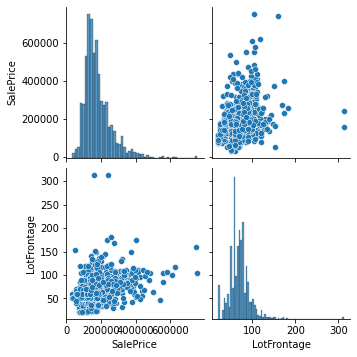

In [14]:
# Checking the importance of column LotFrontage by plotting it against the target variable

sns.pairplot(df[['SalePrice','LotFrontage']])
plt.show()

In [15]:
# Looks like column LotFrontage has a correlation with the target variable, Hence filling the missing value with mean

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

In [16]:
# Dropping further rows with missing value as they are few in numbers

df.dropna(inplace = True)
df.isna().sum()[df.isna().sum() !=0]

Series([], dtype: int64)

In [17]:
# Convert column GarageYrBlt datatype from float to integer

df['GarageYrBlt']
df['GarageYrBlt'] = df['GarageYrBlt'].astype(np.int64)
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['OverallQual'] = df['OverallQual'].astype(str)

## Exploratory Data Analysis

<AxesSubplot:>

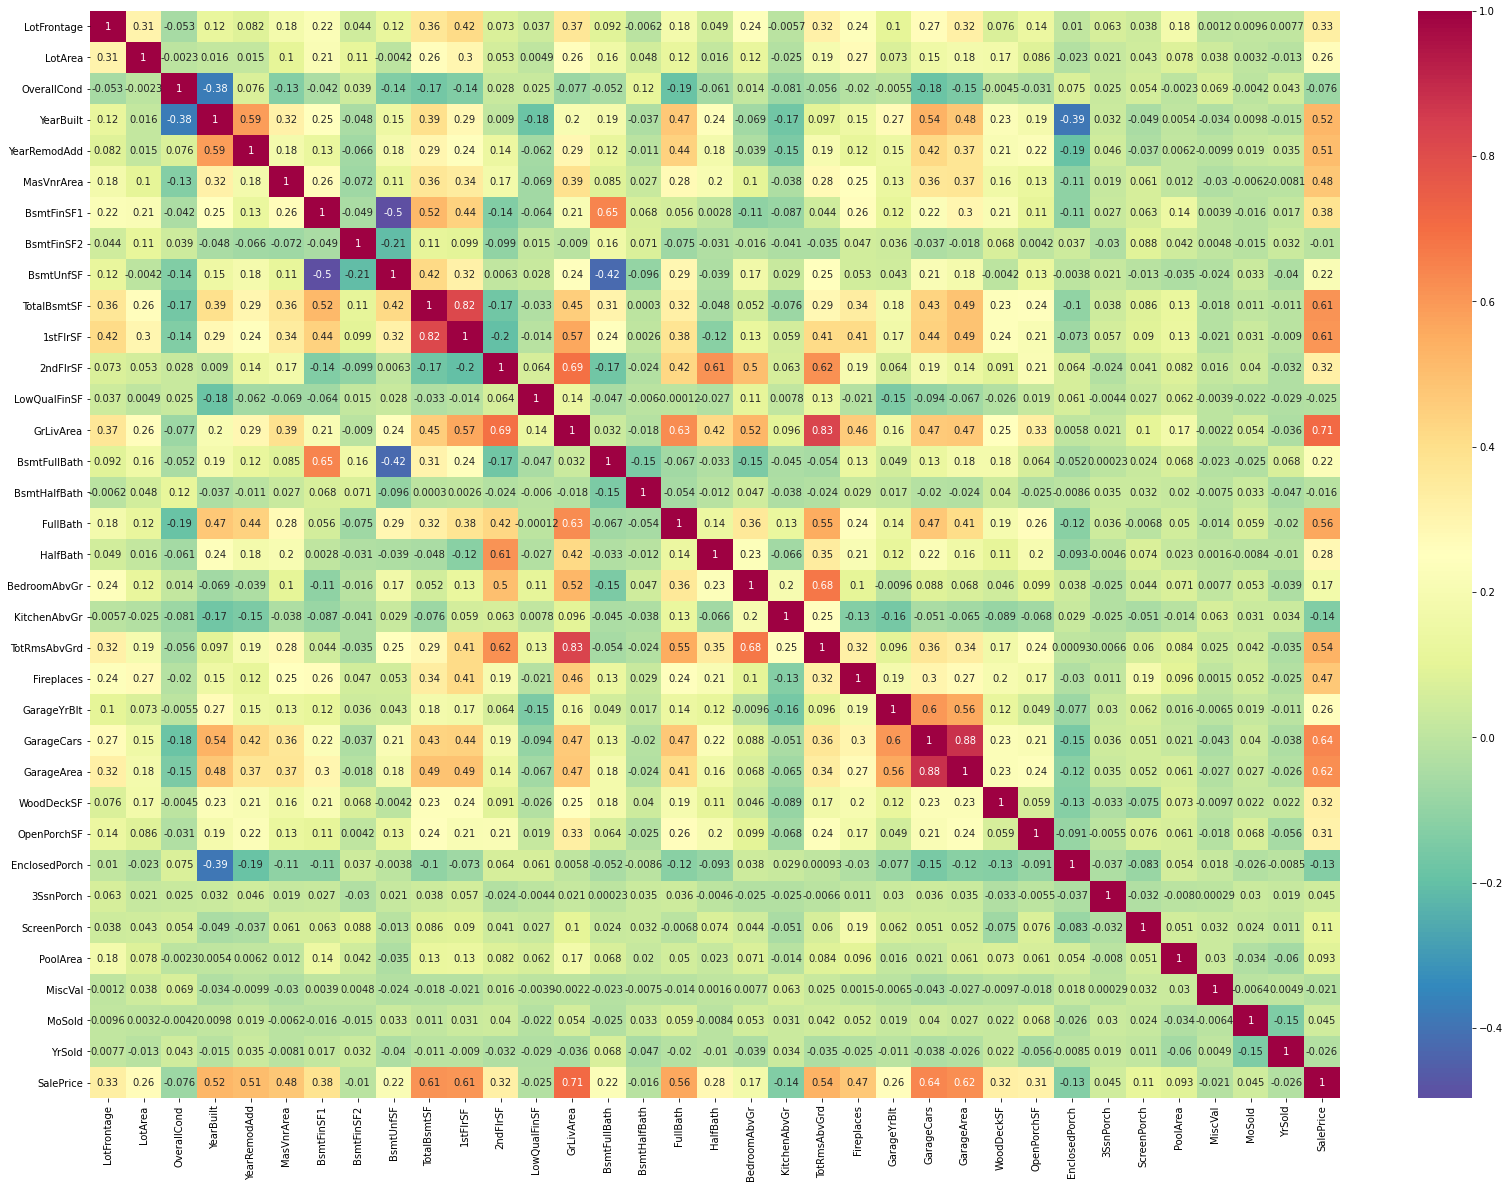

In [18]:
# Plotting a heatmap to visualize the correlation between features

plt.figure(figsize=(28, 20))
sns.heatmap(df.corr(), annot = True, cmap='Spectral_r')

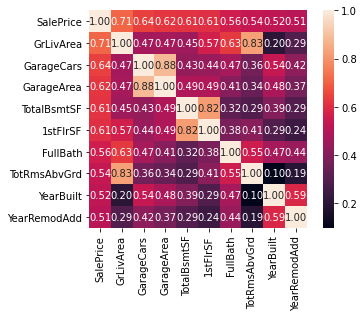

In [19]:
# Due to high number of features, heatmap is not cleary visible to identify the correlation.
# We will look at the top 10 highly correlated variables

corr_matrix = df.corr()
top_10_cols = corr_matrix.nlargest(10,'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[top_10_cols].values.T)
sns.heatmap(cm, square=True, cbar=True, fmt='.2f',annot=True, annot_kws={'size': 10}, yticklabels=top_10_cols.values, xticklabels=top_10_cols.values)
plt.show()

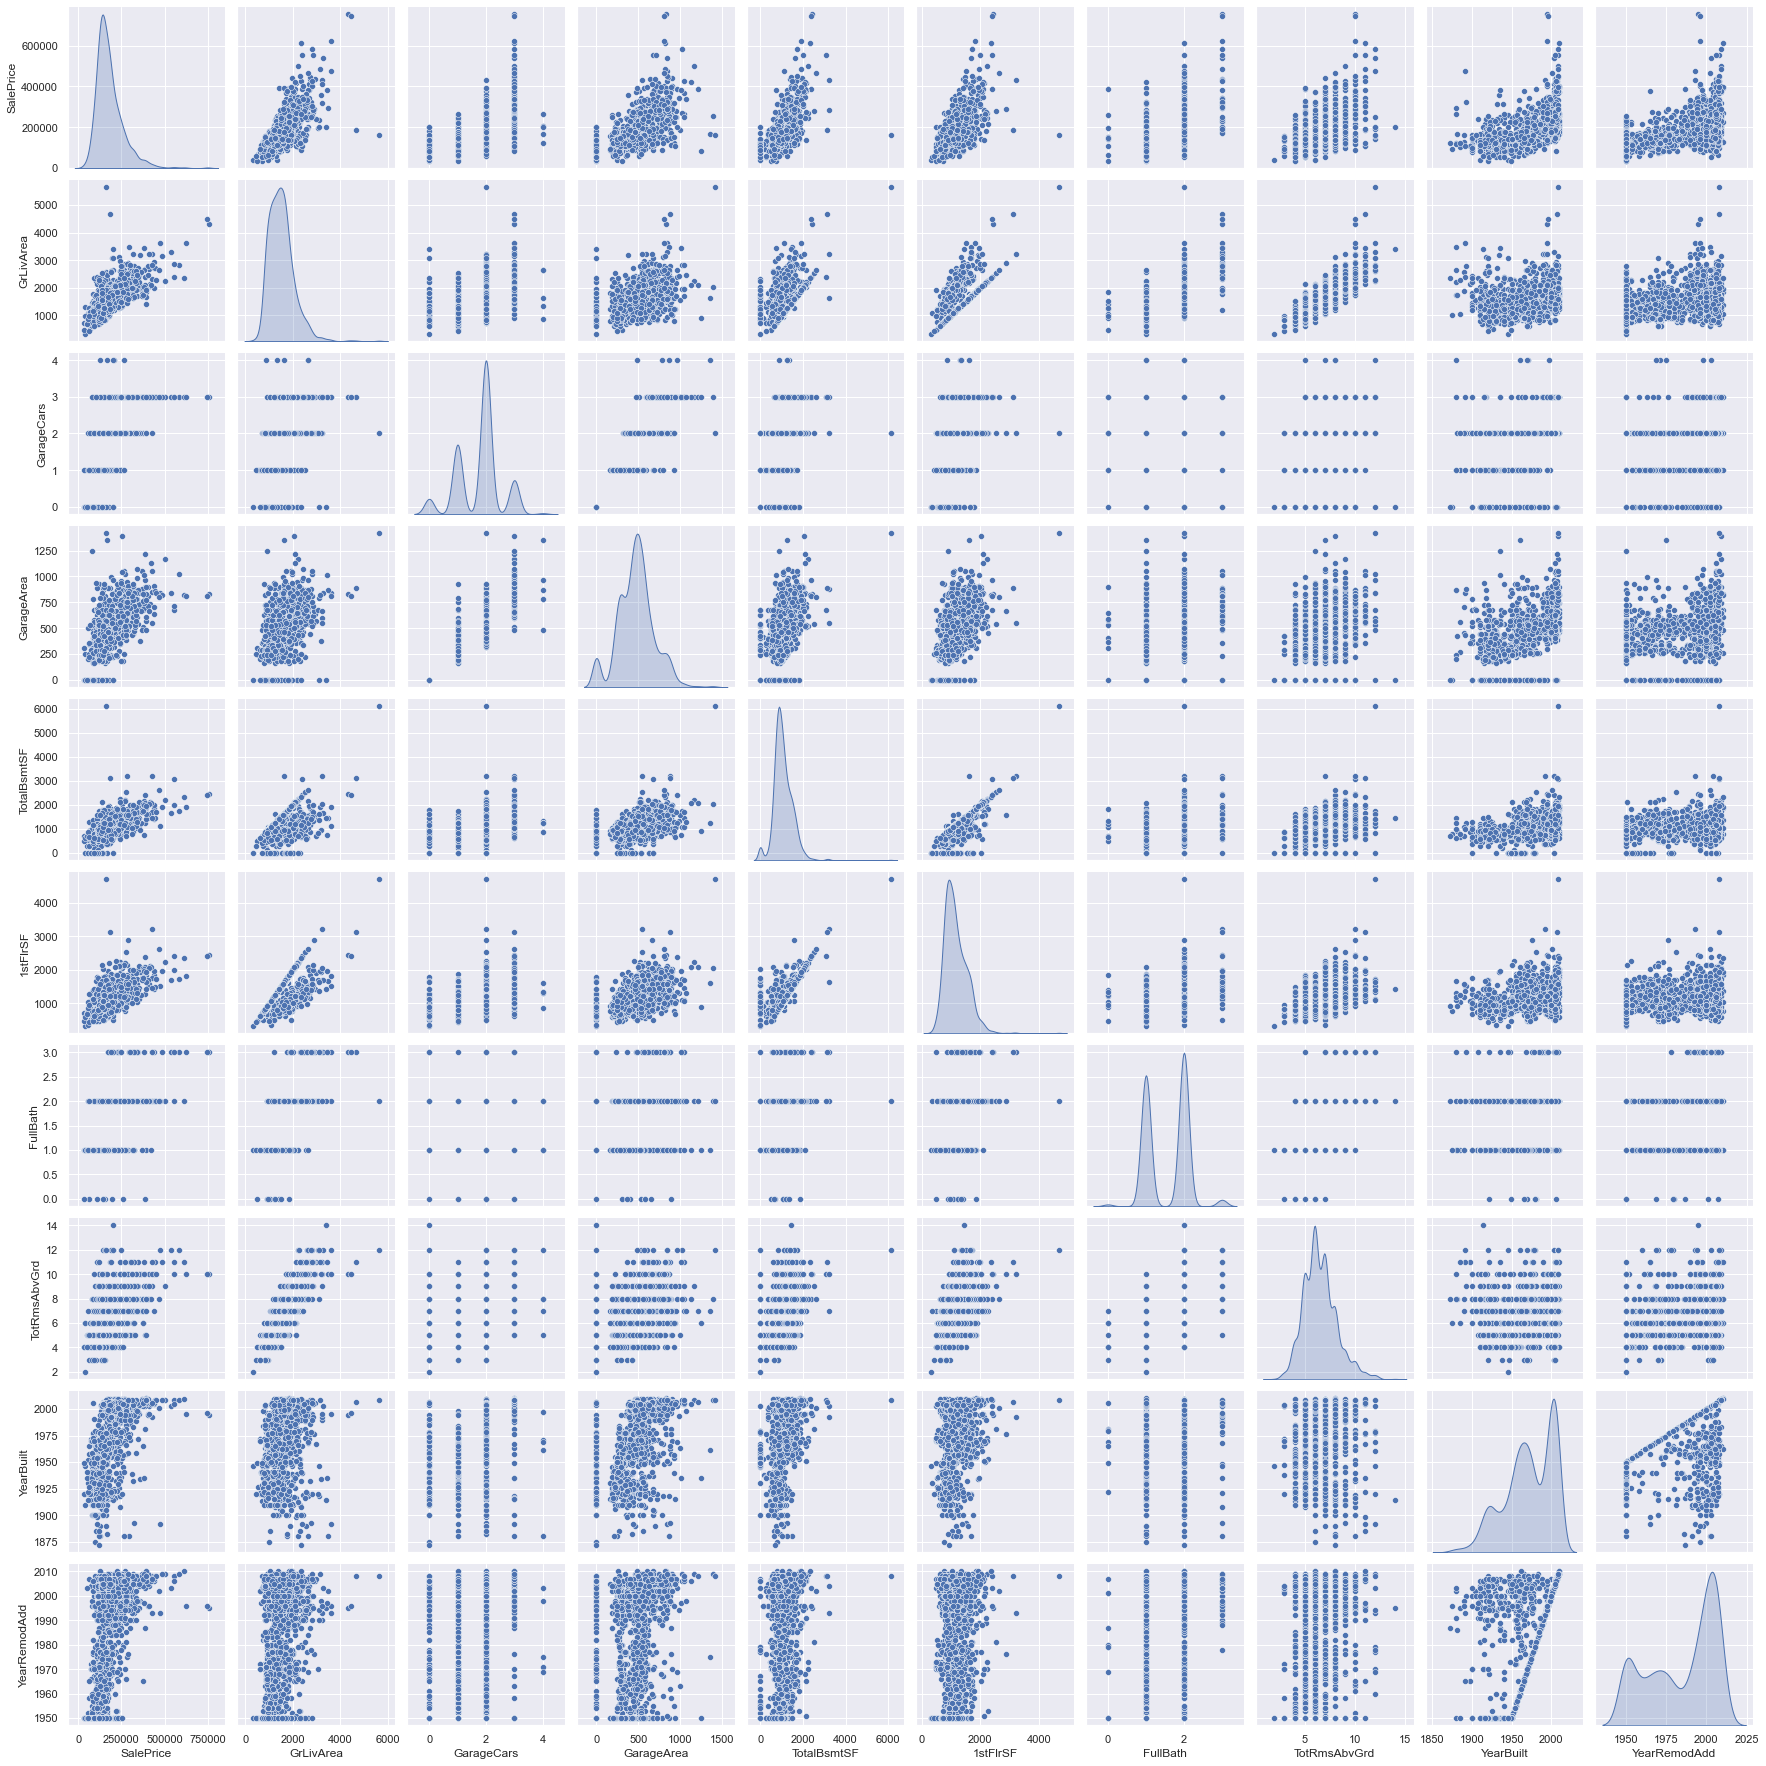

In [20]:
# Plotting a pair plot to see the correlation between the top 10 features

sns.set()
cols = top_10_cols.to_list()
sns.pairplot(df[top_10_cols], diag_kind='kde')
plt.show()

In [21]:
# Identify the highly correlated features to avoid multicolinearity

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
high_corr = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.80)]
high_corr

['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

In [22]:
# Dropping the highly correlated features

df.drop(df[high_corr], axis=1, inplace = True)
df.shape

(1451, 73)

In [23]:
# Identify categorical and numerical columns based on the data types

num_cols = []
cat_cols = []

for col in df.columns:
    if df[col].dtypes == 'object':
        cat_cols.append(col)  
    else:
        num_cols.append(col)
print(f'Categorical columns:  {len(cat_cols)}')

print(f'Numerical columns: {len(num_cols)}')

Categorical columns:  41
Numerical columns: 32


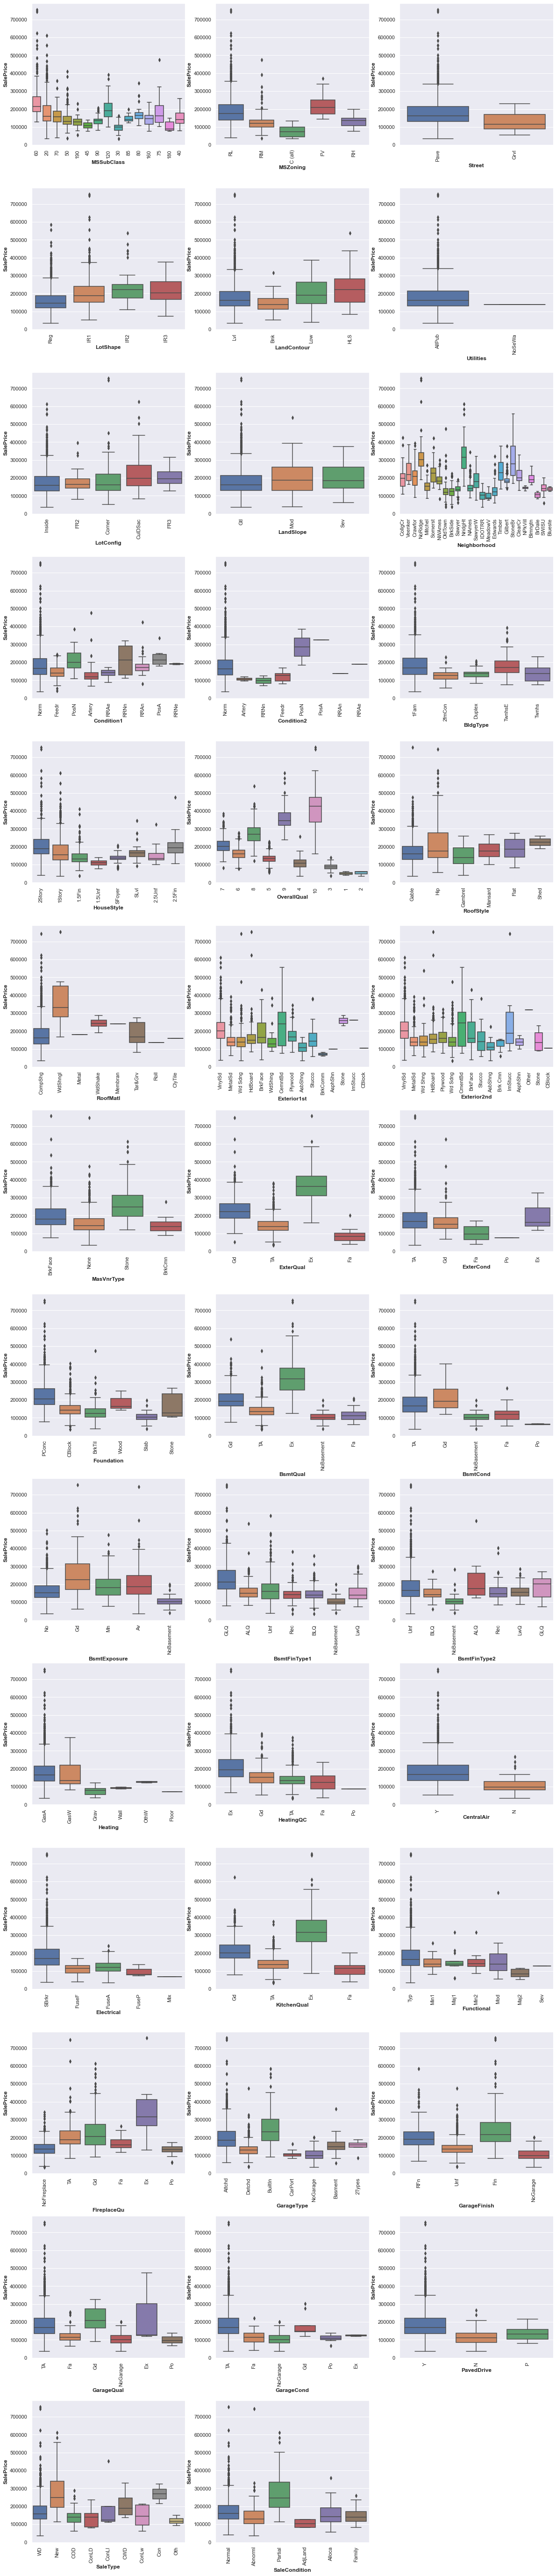

In [24]:
# Plotting series of box plots of categorical variables 

plt.figure(figsize=(20,100))
for i in range(0, len(cat_cols)):
    plt.subplot(14, 3, i+1)
    ax = sns.boxplot(x=cat_cols[i], y='SalePrice', data=df)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
    ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
plt.subplots_adjust(hspace=0.3)
plt.show()

### Univariate and Bivariate Analysis on top features

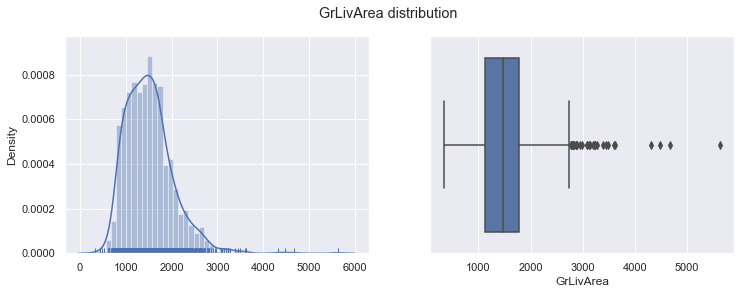

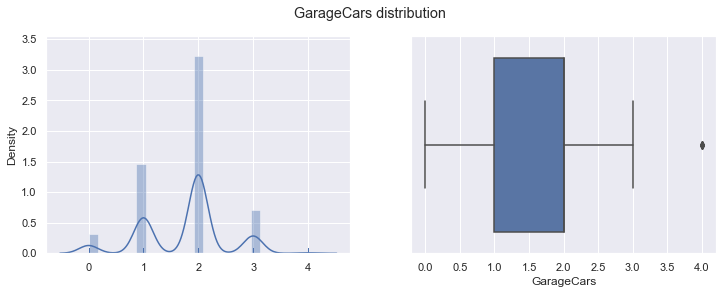

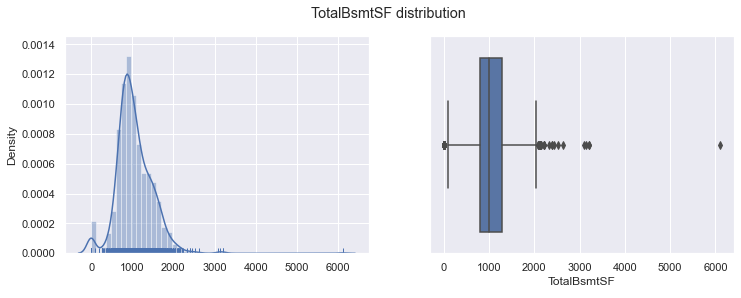

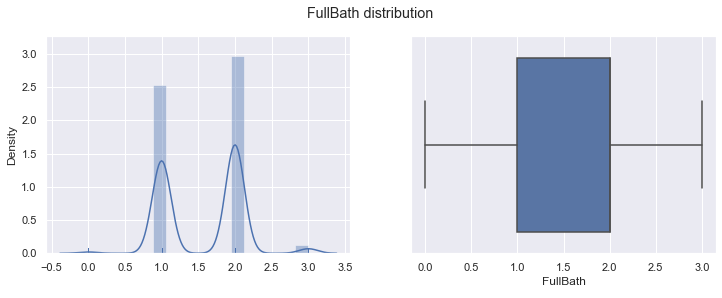

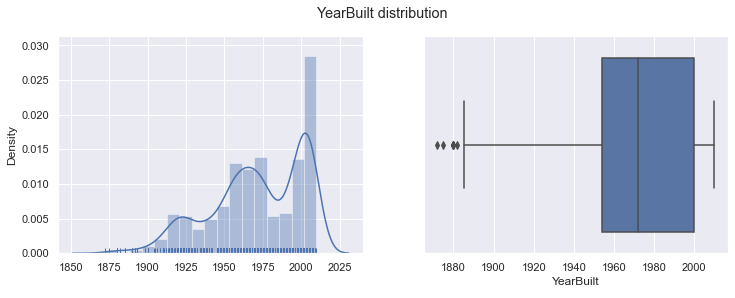

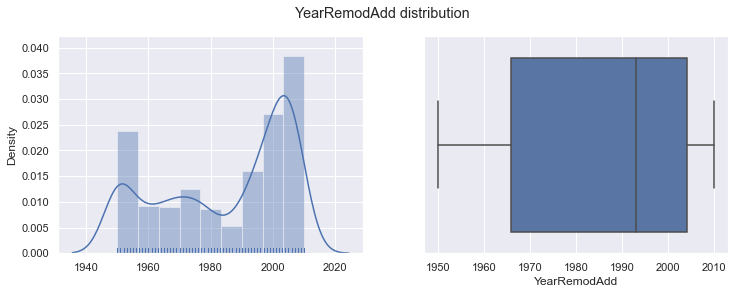

In [25]:
# Plotting a series of top variables to the see the distribution

num_cols_to_plot = [col for col in top_10_cols.to_list() if col not in high_corr]
num_cols_to_plot.remove('SalePrice')
for i in range(0, len(num_cols_to_plot)):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    ax = sns.distplot(df[num_cols_to_plot[i]],rug = True)
    ax.set_xlabel(num_cols_to_plot[i],fontsize=14,color='w')
    plt.subplot(1,2,2)
    sns.boxplot(df[num_cols_to_plot[i]])
    plt.suptitle(f'{num_cols_to_plot[i]} distribution')
    plt.show()

## Data Preparation

### Handling Outliers in continuos variables

In [26]:
# Check for outliers in the top 10 features

df[num_cols_to_plot].describe(percentiles=[.25,.5,.75,.90,.95,.99])

,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,1514.174363,1.764990,1056.310131,1.562371,1971.092350,1984.760165
std,525.799521,0.748728,437.914609,0.550301,30.190266,20.651334
min,334.000000,0.000000,0.000000,0.000000,1872.000000,1950.000000
25%,1128.000000,1.000000,795.000000,1.000000,1954.000000,1966.000000
50%,1464.000000,2.000000,991.000000,2.000000,1972.000000,1993.000000
75%,1776.000000,2.000000,1297.500000,2.000000,2000.000000,2004.000000
90%,2158.000000,3.000000,1602.000000,2.000000,2006.000000,2006.000000
95%,2464.000000,3.000000,1749.000000,2.000000,2007.000000,2007.000000
99%,3126.000000,3.000000,2155.500000,3.000000,2009.000000,2009.000000


In [27]:
# Capping the outliers to the 95th percentile

for column in num_cols_to_plot:
    percentile_95 = df[column].quantile([0.05,0.95]).values
    df[column][df[column] <= percentile_95[0]] = percentile_95[0]
    df[column][df[column] >= percentile_95[1]] = percentile_95[1]

### Creating Dummy variables for categorical columns

In [28]:
# Create Dummy variables for the categorical features

for col in cat_cols:
    dummy_df = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df,dummy_df],axis = 1)
    df = df.drop(columns=[col])
df.shape

(1451, 265)

In [29]:
# Display top 2 rows of dataframe after encoding 

df.head(2)

,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,5,2003,2003,196.0,706,0,150,856,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,8,1976,1976,0.0,978,0,284,1262,...,0,0,0,0,1,0,0,0,1,0


### Feature Scaling

In [30]:
# Instansting StandardScaler object to scale the features

scaler = StandardScaler()

In [31]:
# Scaling the numerical features using StandardScaler

features_to_scale = num_cols.copy()
# features_to_scale.remove('SalePrice')
# X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df.head(2)

,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.228363,-0.205996,-0.520740,1.088092,0.890414,0.509503,0.579345,-0.289621,-0.943764,-0.575319,...,0,0,0,0,1,0,0,0,1,0
1,0.452424,-0.090876,2.174601,0.152011,-0.422535,-0.573097,1.176868,-0.289621,-0.640635,0.598565,...,0,0,0,0,1,0,0,0,1,0


### Train-Test Split

In [32]:
# Create Predictor variables and Target variable from the dataset 

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [33]:
# Split the dataset for training and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (1015, 264)
X_test Shape: (436, 264)
y_train Shape: (1015,)
y_test Shape: (436,)


In [34]:
# Scale the test set using the MixMaxScaler fit on the training data

# X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
# X_test.head(2)

## Model Building

### Linear Regression

#### Training

In [35]:
# Add conastant to the training and test data as we are using statsmodel linear regression

x_train_sm = sm.add_constant(X_train)
x_test_sm = sm.add_constant(X_test, has_constant='add')

In [36]:
# Instantiate Linear Regression model object and train the model

lr_model = sm.OLS(y_train, x_train_sm)
res = lr_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     58.21
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:48:13   Log-Likelihood:                 80.572
No. Observations:                1015   AIC:                             338.9
Df Residuals:                     765   BIC:                             1570.
Df Model:                         249                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -10.6193      0.783    -13.571      0.000     -12.155      -9.083
LotFrontage                 0.0325      0.013      2.416      0.016       0.006       0.059
LotArea                     0.0952      0.015      6.308      0.000       0.066       0.125
OverallCond                 0.0892      0.014      6.203      0.000       0.061       0.117
YearBuilt                   0.0773      0.041      1.880      0.061      -0.003       0.158
YearRemodAdd                0.0346      0.017      2.068      0.039       0.002       0.067
MasVnrArea                  0.0403      0.014      2.839      0.005       0.012       0.068
BsmtFinSF1                  0.6658      0.059     11.371      0.000       0.551       0.781
BsmtFinSF2                  0.2064      0.028      7.439      0.000       0.152       0.261
BsmtUnfSF                   0.5324      0.056      9.526      0.000       0.423       0.642
TotalBsmtSF                -0.2386      0.046     -5.142      0.000      -0.330      -0.148
2ndFlrSF                    0.3213      0.040      8.059      0.000       0.243       0.400
LowQualFinSF               -0.0128      0.015     -0.880      0.379      -0.041       0.016
GrLivArea                   0.1204      0.033      3.674      0.000       0.056       0.185
BsmtFullBath                0.0060      0.015      0.412      0.680      -0.023       0.035
BsmtHalfBath               -0.0143      0.011     -1.304      0.193      -0.036       0.007
FullBath                   -0.0035      0.018     -0.193      0.847      -0.039       0.032
HalfBath                    0.0049      0.016      0.313      0.754      -0.026       0.036
BedroomAbvGr               -0.0086      0.016     -0.548      0.584      -0.040       0.022
KitchenAbvGr               -0.0417      0.021     -1.965      0.050      -0.083    -3.2e-05
Fireplaces                  0.0321      0.024      1.325      0.186      -0.015       0.080
GarageYrBlt                 0.6322      0.429      1.475      0.141      -0.209       1.474
GarageCars                  0.0875      0.019      4.595      0.000       0.050       0.125
WoodDeckSF                  0.0145      0.011      1.347      0.178      -0.007       0.036
OpenPorchSF                 0.0024      0.011      0.231      0.817      -0.018       0.023
EnclosedPorch               0.0022      0.011      0.200      0.842      -0.019       0.024
3SsnPorch                   0.0190      0.008      2.347      0.019       0.003       0.035
ScreenPorch                 0.0035      0.010      0.358      0.721      -0.016       0.023
PoolArea                    0.0498      0.013      3.878      0.000       0.025       0.075
MiscVal                    -0.0165      0.034     -0.490      0.624      -0.083       0.050
MoSold                      0.0070      0.010  

In [37]:
# Defining a generic function to calculate metrics

def metrics(y_true, y_pred, prefix=''):
    metrics = {}
    metrics[f'R2 Score ({prefix})'] = r2_score(y_true, y_pred)
    metrics[f'RSS ({prefix})'] = np.sum(np.square(y_true - y_pred))
    metrics[f'MSE ({prefix})'] = mean_squared_error(y_true, y_pred)
    metrics[f'RMSE ({prefix})'] = mean_squared_error(y_true, y_pred)**0.5
    return metrics

#### Prediction and Evaluation

In [38]:
# Predict y_train and y_test on the trained model

y_train_pred = res.predict(x_train_sm)
y_test_pred = res.predict(x_test_sm)

In [39]:
# Log metrics of training prediction

lr_train = metrics(y_train, y_train_pred, 'Train')
lr_train

{'R2 Score (Train)': 0.9498696471500667,
 'RSS (Train)': 50.70394767767988,
 'MSE (Train)': 0.0499546282538718,
 'RMSE (Train)': 0.22350532041513418}

In [40]:
# Log metrics of test prediction

lr_test = metrics(y_test, y_test_pred, 'Test')
lr_test

{'R2 Score (Test)': 0.43614055757239323,
 'RSS (Test)': 247.63862506753065,
 'MSE (Test)': 0.5679784978613088,
 'RMSE (Test)': 0.7536434819338046}

Text(0.5, 0, 'Errors')

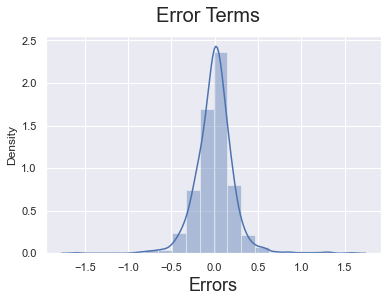

In [41]:
#calculating residuals
residual = y_train - y_train_pred

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)            
plt.xlabel('Errors', fontsize = 18)    

Observations:
    
- R2 score is good.
- The error terms are normally distributed

Text(0, 0.5, 'y_pred')

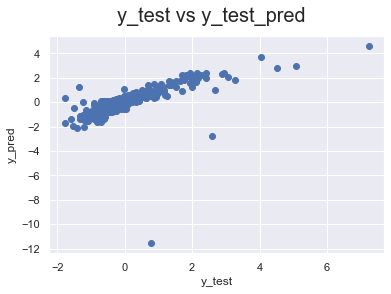

In [42]:
# Plotting y_test and y_test_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)           
plt.xlabel('y_test')                          
plt.ylabel('y_pred')

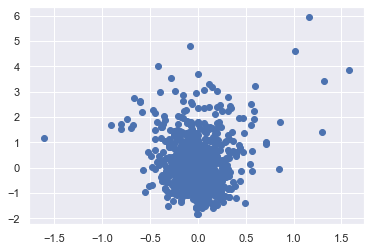

In [43]:
#Checking non-linearity in data by plotting residuals vs predictors
plt.scatter(y_train - y_train_pred, y_train_pred)

### Linear Regression Observations

- It is evident that the model is clearly overfitting
- Residuals are not normally scattered
- No extreme points are found
- The Spread of residuals does not remain constant


#### Hence we will perform regularization using Ridge and Lasso to avoid overfitting and find the best fit

### Ridge Regression

#### Model Training

In [44]:
# Defining paramters for alpha

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# Instantiate the Ridge object from sklearn

ridge = Ridge()

# Performing 5 fold cross validation using ridge estimator to identify the best paramaters

folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        n_jobs = 60,
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

print(model_cv.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 20}


In [45]:
# Train the Ridge model using the paramater identified

alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
# print(ridge.coef_)

Ridge(alpha=20)

#### Prediction and Evaluation

In [46]:
# Predict on the training and test set

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [47]:
# Log metrics for training set predictions

ridge_train = metrics(y_train, y_train_pred, 'Train')
ridge_train

{'R2 Score (Train)': 0.894727185131238,
 'RSS (Train)': 106.47735341034806,
 'MSE (Train)': 0.1049037964633971,
 'RMSE (Train)': 0.3238885556227591}

In [48]:
# Log metrics for test set predictions

ridge_test = metrics(y_test, y_test_pred, 'Test')
ridge_test

{'R2 Score (Test)': 0.860630234654054,
 'RSS (Test)': 61.20911430987624,
 'MSE (Test)': 0.1403878768575143,
 'RMSE (Test)': 0.3746837024178051}

### Lasso Regression

#### Model Training

In [49]:
# Defining paramters for alpha

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# Instantiate the Ridge object from sklearn

lasso = Lasso()

# Performing 5 fold cross validation using ridge estimator to identify the best paramaters

folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        n_jobs = 60,
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

print(model_cv.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 0.001}


In [50]:
# Train the Ridge model using the paramater identified

alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)
# print(lasso.coef_)

Lasso(alpha=0.001)

#### Prediction and Evaluation

In [51]:
# Predict on the training and test set

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

In [52]:
# Log metrics for training set prediction

lasso_train = metrics(y_train, y_train_pred, 'Train')
lasso_train

{'R2 Score (Train)': 0.911911853621044,
 'RSS (Train)': 89.0960568020088,
 'MSE (Train)': 0.08777936630739784,
 'RMSE (Train)': 0.2962758280849078}

In [53]:
# Log metrics for test set prediction

lasso_test = metrics(y_test, y_test_pred, 'Test')
lasso_test

{'R2 Score (Test)': 0.8675511838141392,
 'RSS (Test)': 58.16953705851922,
 'MSE (Test)': 0.13341636940027343,
 'RMSE (Test)': 0.36526205579046045}

Text(0.5, 0, 'Errors')

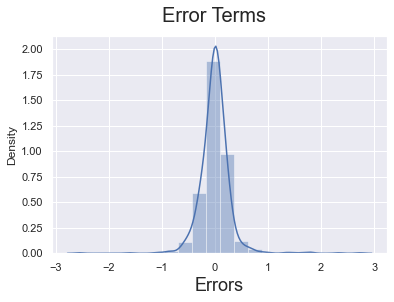

In [54]:
#calculating residuals
residual = y_train - y_train_pred

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)            
plt.xlabel('Errors', fontsize = 18)    

- The Error terms are normally distributed

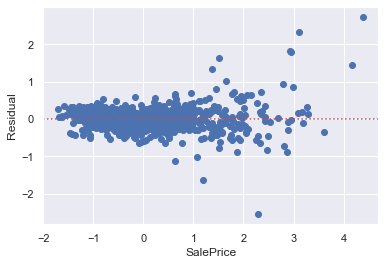

In [55]:
#Checking non-linearity in data by plotting residuals vs predictors

plt.scatter(y_train_pred, residual)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("SalePrice")
plt.ylabel("Residual")
plt.show()

Text(0, 0.5, 'y_pred')

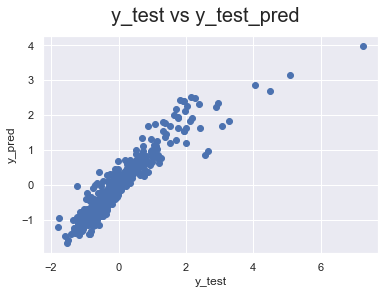

In [56]:
# Plotting y_test and y_test_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)           
plt.xlabel('y_test')                          
plt.ylabel('y_pred')

In [57]:
metrics_df = pd.DataFrame({'Metrics' : ['R2 Score (Train)', 'R2 Score (Test)', 'RSS (Train)', 'RSS (Test)', 
                                       'MSE (Train)', 'MSE (Test)', 'RMSE (Train)', 'RMSE (Test)'], 
 'Linear Regression': [lr_train['R2 Score (Train)'], lr_test['R2 Score (Test)'],
                       lr_train['RSS (Train)'], lr_test['RSS (Test)'],
                       lr_train['MSE (Train)'], lr_test['MSE (Test)'],
                       lr_train['MSE (Train)'], lr_test['RMSE (Test)']],
 'Ridge Regression': [ridge_train['R2 Score (Train)'], ridge_test['R2 Score (Test)'],
                       ridge_train['RSS (Train)'], ridge_test['RSS (Test)'],
                       ridge_train['MSE (Train)'], ridge_test['MSE (Test)'],
                       ridge_train['MSE (Train)'], ridge_test['RMSE (Test)']],
 'Lasso Regression': [lasso_train['R2 Score (Train)'], lasso_test['R2 Score (Test)'],
                       lasso_train['RSS (Train)'], lasso_test['RSS (Test)'],
                       lasso_train['MSE (Train)'], lasso_test['MSE (Test)'],
                       lasso_train['MSE (Train)'], lasso_test['RMSE (Test)']]
})
metrics_df

,Metrics,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.949870,0.894727,0.911912
1,R2 Score (Test),0.436141,0.860630,0.867551
2,RSS (Train),50.703948,106.477353,89.096057
3,RSS (Test),247.638625,61.209114,58.169537
4,MSE (Train),0.049955,0.104904,0.087779
5,MSE (Test),0.567978,0.140388,0.133416
6,RMSE (Train),0.049955,0.104904,0.087779
7,RMSE (Test),0.753643,0.374684,0.365262


In [58]:
# Generic function to return coeffient and column name in sorted order

def get_sorted_coef(model, X_train):
    coef_list = []
    for (coef,column) in zip(model.coef_, X_train.columns):
        coef_list.append((coef,column))
    return sorted(coef_list, key=lambda x:x[0], reverse=True)

In [59]:
# Display top 5 coefficients for Ridge

sorted_ridge_coef = get_sorted_coef(ridge, X_train)
sorted_ridge_coef[:5]

[(0.3086408493919478, 'OverallQual_10'),
 (0.30654317829359246, 'OverallQual_9'),
 (0.268158164062536, 'GrLivArea'),
 (0.2516245865790931, 'TotalBsmtSF'),
 (0.22475233806540434, 'Neighborhood_NoRidge')]

In [60]:
# Display top 5 coefficients for Lasso

sorted_lasso_coef = get_sorted_coef(lasso, X_train)
sorted_lasso_coef[:5]

[(1.36699074600119, 'OverallQual_10'),
 (0.9494724126488553, 'OverallQual_9'),
 (0.39271981786517846, 'Neighborhood_NoRidge'),
 (0.30382150524040236, 'Neighborhood_Crawfor'),
 (0.294317761574898, 'TotalBsmtSF')]

### Conclusion :
    
#### we got a decent score for both Ridge and Lasso regression.

 - Ridge : Train :89.47 Test :86.06
 - Lasso : Train :91.19 Test :86.75
 
#### Top 5 most significant variables in Ridge are:
- OverallQual_10
- OverallQual_9
- GrLivArea
- TotalBsmtSF
- Neighborhood_NoRidge

#### Top 5 most significant variables in Lasso are:
- OverallQual_10
- OverallQual_9
- Neighborhood_NoRidge
- Neighborhood_Crawfor
- TotalBsmtSF

#### Optimal Value of lamda for ridge : 20
#### Optimal Value of lamda for Lasso : 0.001

### We can choose the lasso model as it performs better with the feature selection.

# Problem Statement II

## Subjective Question 1 - Workout

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

#### Ridge regresison - Optimal alpha = 20
#### Lasso regresison - Optimal alpha = 0.001

In [61]:
# We will create a new model by doubling the alpha to to determine the changes in the model and the predictor

ridge_alpha_double = 40
lasso_alpha_double = 0.002

#Ridge alpha double regression model
ridge_double = Ridge(alpha=ridge_alpha_double)
ridge_double_model = ridge_double.fit(X_train, y_train)

#Lasso alpha doube regression model
lasso_double = Lasso(alpha=lasso_alpha_double)   
lasso_double_model = lasso_double.fit(X_train, y_train)

In [62]:
# Predict on the ridge training and test sets

y_train_pred = ridge_double_model.predict(X_train)
y_test_pred = ridge_double_model.predict(X_test)

In [63]:
# Get metrics for ridge training and test predictions

ridge_train_double = metrics(y_train, y_train_pred, 'Train')
ridge_test_double = metrics(y_test, y_test_pred, 'Test')
ridge_train_double.update(ridge_test_double)
ridge_train_double

{'R2 Score (Train)': 0.8825982576381042,
 'RSS (Train)': 118.74506089765026,
 'MSE (Train)': 0.11699020778093622,
 'RMSE (Train)': 0.34203831332313667,
 'R2 Score (Test)': 0.8542249140799257,
 'RSS (Test)': 64.02223520622005,
 'MSE (Test)': 0.14683998900509185,
 'RMSE (Test)': 0.3831970628868283}

In [64]:
# Predict on the lasso training and test sets

y_train_pred = lasso_double_model.predict(X_train)
y_test_pred = lasso_double_model.predict(X_test)

In [65]:
# Get metrics for lasso training and test predictions

lasso_train_double = metrics(y_train, y_train_pred, 'Train')
lasso_test_double = metrics(y_test, y_test_pred, 'Test')
lasso_train_double.update(lasso_test_double)
lasso_train_double

{'R2 Score (Train)': 0.9001613248701101,
 'RSS (Train)': 100.9810358835637,
 'MSE (Train)': 0.09948870530400365,
 'RMSE (Train)': 0.31541830210690636,
 'R2 Score (Test)': 0.8653180160470452,
 'RSS (Test)': 59.15031090706447,
 'MSE (Test)': 0.1356658507042763,
 'RMSE (Test)': 0.36832845492070837}

In [66]:
# Identifying the important coefficient and column for ridge

sorted_ridge_coef_double = get_sorted_coef(ridge_double_model, X_train)
sorted_ridge_coef_double[:5]

[(0.26028895194150586, 'GrLivArea'),
 (0.23173255650751962, 'TotalBsmtSF'),
 (0.22749620227182102, 'OverallQual_9'),
 (0.19383062538323415, 'OverallQual_10'),
 (0.15532683466352615, 'Neighborhood_NridgHt')]

In [67]:
# Identifying the important coefficient and column for ridge

sorted_lasso_coef_double = get_sorted_coef(lasso_double_model, X_train)
sorted_lasso_coef_double[:5]

[(1.190015671994599, 'OverallQual_10'),
 (0.880195618799713, 'OverallQual_9'),
 (0.36726563602943885, 'Neighborhood_NoRidge'),
 (0.2988716345927052, 'TotalBsmtSF'),
 (0.28795587567770903, 'Neighborhood_Crawfor')]

In [68]:
# Append the Double Regression metrics to the dataframe

metrics_df['Ridge Double Regression'] = metrics_df['Metrics'].map(ridge_train_double)
metrics_df['Lasso Double Regression'] = metrics_df['Metrics'].map(lasso_train_double)
metrics_df

,Metrics,Linear Regression,Ridge Regression,Lasso Regression,Ridge Double Regression,Lasso Double Regression
0,R2 Score (Train),0.949870,0.894727,0.911912,0.882598,0.900161
1,R2 Score (Test),0.436141,0.860630,0.867551,0.854225,0.865318
2,RSS (Train),50.703948,106.477353,89.096057,118.745061,100.981036
3,RSS (Test),247.638625,61.209114,58.169537,64.022235,59.150311
4,MSE (Train),0.049955,0.104904,0.087779,0.116990,0.099489
5,MSE (Test),0.567978,0.140388,0.133416,0.146840,0.135666
6,RMSE (Train),0.049955,0.104904,0.087779,0.342038,0.315418
7,RMSE (Test),0.753643,0.374684,0.365262,0.383197,0.368328


## Subjective Question 3 - Workout

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [69]:
# We will train another model excluding the top 5 predictors in the lasso model
# Lets find the top 5 predictors

sorted_lasso_coef[:5]

[(1.36699074600119, 'OverallQual_10'),
 (0.9494724126488553, 'OverallQual_9'),
 (0.39271981786517846, 'Neighborhood_NoRidge'),
 (0.30382150524040236, 'Neighborhood_Crawfor'),
 (0.294317761574898, 'TotalBsmtSF')]

In [70]:
# Drop the 5 features from the training data
top_5_cols = [j for (i,j) in sorted_lasso_coef[:5]]
X_train_dropped_top_5 = X_train.drop(columns=top_5_cols, axis=0)

In [71]:
# Train a lasso model after dropping the top 5 features

lasso_excluding_top_5 = Lasso(alpha=0.001)
lasso_excluding_top_5_model = lasso_excluding_top_5.fit(X_train_dropped_top_5, y_train)

In [72]:
# Identifying the important coefficient and column for lasso model after dropping top5 features

sorted_lasso_coef_excluding_top_5 = get_sorted_coef(lasso_excluding_top_5_model, X_train_dropped_top_5)
sorted_lasso_coef_excluding_top_5[:5]

[(0.47399248143624517, 'RoofMatl_WdShngl'),
 (0.4116382781992408, 'Exterior2nd_ImStucc'),
 (0.349337291412178, 'GrLivArea'),
 (0.25448745970111936, 'RoofMatl_CompShg'),
 (0.23799742048083855, 'Exterior1st_BrkFace')]

### Top five predictors now is :

- RoofMatl_WdShngl (0.47399248143624517)
- Exterior2nd_ImStucc (0.4116382781992408)
- GrLivArea (0.349337291412178)
- RoofMatl_CompShg (0.25448745970111936)
- Exterior1st_BrkFace (0.23799742048083855)